# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

# Solution:
**As I am in India, I will do this for indian market. let us first collect data available in indian market, specifically list of NIFTY50**

In [43]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
import random
import yfinance as yf

nse_symbols = pd.read_csv('MW-NIFTY-50-03-Jun-2025.csv')  # Make sure this file contains the 'Symbol' column
nse_symbols.columns = nse_symbols.columns.str.replace(' \n','')

valid_tickers = []

for symbol in nse_symbols['SYMBOL']:
    ticker = symbol + ".NS"
    try:
        data = yf.Ticker(ticker).history(period="365d")
        if not data.empty:
            valid_tickers.append(ticker)
    except:
        pass

print(f"Number of valid NSE tickers on yfinance: {len(valid_tickers)}")

start_date = dt.datetime.today()-dt.timedelta(days = 2*365)
end_date = dt.datetime.today()

stock = yf.download(valid_tickers, start = start_date, end =end_date)

Number of valid NSE tickers on yfinance: 50


[*********************100%***********************]  50 of 50 completed


**Let us first do the toy case for three tickers**

In [48]:
#let us define daily return for each share

close = stock['Close']
normalized_returns = close/close.iloc[0]-1 #Moves stock prices to a start of 0


# Step 2: Create MultiIndex columns for new data
normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

# Step 3: Concatenate to the original DataFrame
stock = pd.concat([stock, normalized_returns], axis =1 )
stock.head()

Close                                                        \
Ticker      ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS AXISBANK.NS   
Date                                                                            
2023-06-05  2430.537598    730.731201   4913.138672   3137.259521  948.166077   
2023-06-06  2430.237793    737.259155   4903.114746   3150.005615  965.467102   
2023-06-07  2436.129639    735.627197   4988.818359   3161.820312  973.993042   
2023-06-08  2425.744141    728.357483   4889.765137   3149.515381  959.384338   
2023-06-09  2447.713379    726.923340   4889.814941   3139.201172  971.998596   

                                                                  \
Ticker     BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS      BEL.NS   
Date                                                               
2023-06-05   4533.391113   1457.212280   6935.570801  113.341187   
2023-06-06   4548.983398   1473.393433   7005.239746  115.693268   
2023-06-07   4601.439453   1479.186768   6971.758789  115.693268   
2023-06-08   4620.593262   1465.702393   6902.976562  115.203247   
2023-06-09   4565.490234   1464.803345   6929.612305  117.947350   

                          ... Cumulative Return                              \
Ticker     BHARTIARTL.NS  ...      SUNPHARMA.NS TATACONSUM.NS TATAMOTORS.NS   
Date                      ...                                                 
2023-06-05    826.080688  ...          0.000000      0.000000      0.000000   
2023-06-06    821.081665  ...          0.005006     -0.000442      0.017391   
2023-06-07    835.732300  ...          0.005799      0.038678      0.039725   
2023-06-08    827.565552  ...         -0.021561      0.018487      0.024622   
2023-06-09    825.090759  ...         -0.024585      0.010789      0.029382   

                                                                               \
Ticker     TATASTEEL.NS    TCS.NS  TECHM.NS  TITAN.NS  TRENT.NS ULTRACEMCO.NS   
Date                                                                            
2023-06-05     0.000000  0.000000  0.000000  0.000000  0.000000      0.000000   
2023-06-06    -0.003656 -0.017209 -0.020823  0.009017  0.002251      0.028870   
2023-06-07     0.019196 -0.004257 -0.012304  0.017946  0.002376      0.034966   
2023-06-08     0.015996 -0.015947 -0.034299  0.007459 -0.006535      0.027677   
2023-06-09    -0.004570 -0.024203 -0.041736  0.007196 -0.000407      0.034414   

                      
Ticker      WIPRO.NS  
Date                  
2023-06-05  0.000000  
2023-06-06 -0.010515  
2023-06-07 -0.003464  
2023-06-08 -0.011504  
2023-06-09 -0.017071  

[5 rows x 300 columns]

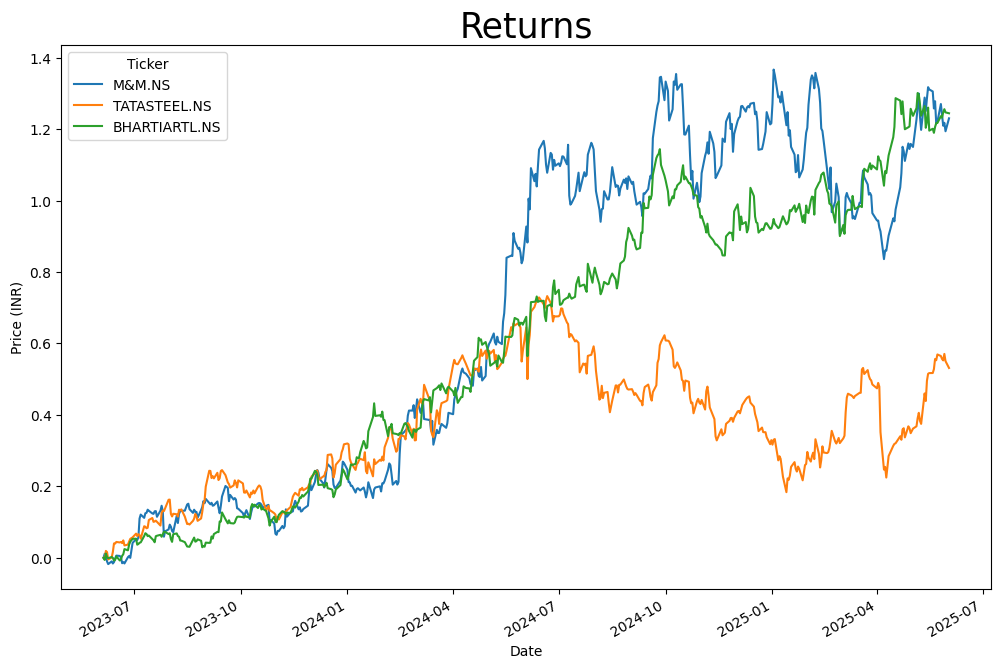

In [49]:
#Let us verify whether everything is alright by ploting data for randomly chosen three share

three_random_tickers = random.sample(valid_tickers, 3)

stock['Cumulative Return'][three_random_tickers].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (INR)')
plt.show()


**The range of fluctuations for all shares may be very large. so we consider log returns for smoother calculations**

In [63]:
# daily_log_returns = np.log(stock['Close']/stock['Close'].shift(1))
# daily_log_returns = daily_log_returns.dropna()
# daily_log_returns
daily_log_returns = np.log(stock['Close'] / stock['Close'].shift(1)).dropna()
daily_log_returns.index = pd.to_datetime(daily_log_returns.index)
yearly_log_returns = daily_log_returns.groupby(daily_log_returns.index.year).sum()
yearly_log_returns

Ticker,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BEL.NS,BHARTIARTL.NS,...,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,TRENT.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2025,0.129569,0.278955,0.034153,-0.032403,0.130808,0.152848,0.090926,0.068423,0.353546,0.094655,...,0.004939,0.074807,0.204919,0.205629,0.052289,0.184583,0.154037,0.170361,0.000304,0.019488


**We can now define volatility for each of these equities:**

In [51]:
annualized_volatility = {ticker: np.std(daily_log_returns[ticker])*np.sqrt(252) for ticker in valid_tickers}

In [118]:
covariance_matrix = 252*((daily_log_returns).cov())
covariance_matrix

Ticker,ADANIENT.NS,ADANIPORTS.NS,APOLLOHOSP.NS,ASIANPAINT.NS,AXISBANK.NS,BAJAJ-AUTO.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BEL.NS,BHARTIARTL.NS,...,SUNPHARMA.NS,TATACONSUM.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,TRENT.NS,ULTRACEMCO.NS,WIPRO.NS
Ticker,,,,,,,,,,,,,,,,,,,,,
ADANIENT.NS,0.149037,0.096620,0.045011,0.041313,0.061145,0.070913,0.073850,0.071951,0.049155,0.028112,...,0.015977,0.040263,0.058928,0.068289,0.034179,0.047036,0.019180,0.106562,0.039674,0.068219
ADANIPORTS.NS,0.096620,0.097559,0.034030,0.029552,0.045944,0.030348,0.053752,0.050097,0.020761,0.030607,...,0.016685,0.023721,0.040509,0.038565,0.017521,0.014333,0.006242,0.076313,0.024678,0.037490
APOLLOHOSP.NS,0.045011,0.034030,0.038972,0.027217,0.038136,0.035658,0.035827,0.025550,0.016249,0.023343,...,0.007631,0.025341,0.019224,0.027364,0.017844,0.021682,0.007673,0.040640,0.021909,0.022319
ASIANPAINT.NS,0.041313,0.029552,0.027217,0.041317,0.028253,0.033503,0.029268,0.016532,0.020609,0.014736,...,0.009783,0.030956,0.017521,0.013861,0.020203,0.016942,0.011745,0.036434,0.017710,0.021505
AXISBANK.NS,0.061145,0.045944,0.038136,0.028253,0.077311,0.038949,0.047307,0.039554,0.023106,0.030349,...,0.009571,0.020620,0.030033,0.041848,0.025874,0.037000,0.015846,0.070343,0.026214,0.036843
BAJAJ-AUTO.NS,0.070913,0.030348,0.035658,0.033503,0.038949,0.092631,0.050558,0.041401,0.037955,0.029540,...,0.016265,0.029900,0.037478,0.044583,0.023074,0.041337,0.021596,0.059639,0.030960,0.035225
BAJAJFINSV.NS,0.073850,0.053752,0.035827,0.029268,0.047307,0.050558,0.092571,0.068709,0.029994,0.028163,...,0.006325,0.032993,0.047378,0.049741,0.031881,0.039428,0.015032,0.089004,0.033751,0.034329
BAJFINANCE.NS,0.071951,0.050097,0.025550,0.016532,0.039554,0.041401,0.068709,0.076866,0.031735,0.015366,...,-0.000466,0.021240,0.050940,0.046730,0.021909,0.031157,0.012721,0.066883,0.030413,0.037684
BEL.NS,0.049155,0.020761,0.016249,0.020609,0.023106,0.037955,0.029994,0.031735,0.079614,-0.000223,...,0.013939,0.019938,0.029559,0.025789,0.005631,0.023152,0.017467,0.036755,-0.000985,0.018518


Okay! We have all the data for each share. We will now create two portfolios and compare the risk.**

In [68]:
#we will first choose 10 shares which have minimal volatility, and 10 shares which have the highest profit. we will find the ideal weights which gives minimal volatility and compare the minimal volatility in both the cases.
#we don't have any constraints.
#Create dictionary average/expected daily return for indexes in stock_symbols normalized for yearly return
# 1. Get the latest year
latest_year = yearly_log_returns.index.max()

# 2. Extract returns for the latest year
latest_returns = yearly_log_returns.loc[latest_year]

# 3. Sort and select top 10
top_10 = latest_returns.sort_values(ascending=False).head(10)

print(f"Top 10 stocks by return in {latest_year} are {top_10}")


Top 10 stocks by return in 2025 are Ticker
BEL.NS           0.353546
JIOFIN.NS        0.293834
ADANIPORTS.NS    0.278955
SBILIFE.NS       0.210190
TATASTEEL.NS     0.205629
TATAMOTORS.NS    0.204919
M&M.NS           0.194424
RELIANCE.NS      0.192889
TECHM.NS         0.184583
INDUSINDBK.NS    0.184317
Name: 2025, dtype: float64


In [80]:
# Sort tickers by annualized volatility in ascending order
least_volatile = sorted(annualized_volatility.items(), key=lambda x: x[1])[:10]

# Extract just the ticker symbols
least_volatile_tickers = [ticker for ticker, vol in least_volatile]
portfolio_B = least_volatile_tickers
print("10 least volatile tickers:", least_volatile_tickers)

10 least volatile tickers: ['TITAN.NS', 'ITC.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS', 'HDFCBANK.NS', 'APOLLOHOSP.NS', 'DRREDDY.NS', 'ASIANPAINT.NS', 'HINDUNILVR.NS', 'TATACONSUM.NS']


**Call them Portfolio A and Portfolio B, respectively. Let us first find the weights to be assigned for each stock and the volatility for Portfolio A.**

In [101]:
#For portfolio A
portfolio_A = top_10.keys()

n_assets = len(portfolio_A)
# defining initial weights
initial_weights = np.array([1/n_assets] * n_assets)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
              {'type': 'ineq', 'fun': lambda weights: weights})

#let's define covariance matrix for stocks from Portfolio A
#daily_log_returns_A = covariance_matrix.loc[portfolio_A, portfolio_A]
covariance_matrix_A = covariance_matrix.loc[portfolio_A, portfolio_A]

def portfolio_volatility(weights):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix_A, weights)))
    return portfolio_std_dev
    
# Run the optimization to find the optimal weights
result = minimize(portfolio_volatility, initial_weights, constraints=constraints)
# Optimal asset weights
optimal_weights = result.x

# Print the optimal weights and expected returns
print("Optimal Asset Weights to minimize volatility:")
for ticker, weight in zip(portfolio_A, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")


print(f' The optimal volatility for portfolio_A is {result.fun}')

Optimal Asset Weights to minimize volatility:
BEL.NS: Weight = 0.3145
JIOFIN.NS: Weight = -0.0000
ADANIPORTS.NS: Weight = 0.0478
SBILIFE.NS: Weight = 0.3209
TATASTEEL.NS: Weight = -0.0000
TATAMOTORS.NS: Weight = 0.0370
M&M.NS: Weight = 0.0953
RELIANCE.NS: Weight = 0.0000
TECHM.NS: Weight = 0.0245
INDUSINDBK.NS: Weight = 0.1600
 The optimal volatility for portfolio_A is 0.16418622565972255


**Now, we want to repeat the process for Portfolio B. Rather we would generalize it for any given portfolio.**

In [122]:
portfolio_C = random.sample(valid_tickers, 10)

portfolios = {'portfolio_A': portfolio_A, 
              'portfolio_B': portfolio_B,
              'portfolio_C': portfolio_C}

for name, t in portfolios.items():
    n_assets = len(t)
    # defining initial weights
    initial_weights = np.array([1/n_assets] * n_assets)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1},
                  {'type': 'ineq', 'fun': lambda weights: weights})

    #let's define covariance matrix for stocks from Portfolio A
   # daily_log_returns_new = covariance_matrix.loc[t, t]
    covariance_matrix_new = covariance_matrix.loc[t, t]

    def portfolio_volatility(weights):
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix_new, weights)))
        return portfolio_std_dev
    
# Run the optimization to find the optimal weights
    result = minimize(portfolio_volatility, initial_weights, constraints=constraints)
# Optimal asset weights
    optimal_weights = result.x

    #returns:
    returns = yearly_log_returns[t].iloc[0].values
    portfolio_return = np.dot(optimal_weights, returns)
# Print the optimal weights and expected returns
   
    print(f"\nOptimal Asset Weights to minimize volatility for {name}:")
    for ticker, weight in zip(t, optimal_weights):
        print(f"{ticker}: Weight = {weight:.4f}")
    
    print(f"The optimal volatility for {name} is {result.fun:.4f}\n The annual return is {portfolio_return}.")


Optimal Asset Weights to minimize volatility for portfolio_A:
BEL.NS: Weight = 0.3145
JIOFIN.NS: Weight = -0.0000
ADANIPORTS.NS: Weight = 0.0478
SBILIFE.NS: Weight = 0.3209
TATASTEEL.NS: Weight = -0.0000
TATAMOTORS.NS: Weight = 0.0370
M&M.NS: Weight = 0.0953
RELIANCE.NS: Weight = 0.0000
TECHM.NS: Weight = 0.0245
INDUSINDBK.NS: Weight = 0.1600
The optimal volatility for portfolio_A is 0.1642
 The annual return is 0.25210049540409063.

Optimal Asset Weights to minimize volatility for portfolio_B:
TITAN.NS: Weight = 0.2417
ITC.NS: Weight = 0.0681
NESTLEIND.NS: Weight = 0.0000
ULTRACEMCO.NS: Weight = 0.1324
HDFCBANK.NS: Weight = 0.0370
APOLLOHOSP.NS: Weight = 0.0000
DRREDDY.NS: Weight = 0.2362
ASIANPAINT.NS: Weight = 0.0268
HINDUNILVR.NS: Weight = 0.2578
TATACONSUM.NS: Weight = 0.0000
The optimal volatility for portfolio_B is 0.1273
 The annual return is 0.08935220914850482.

Optimal Asset Weights to minimize volatility for portfolio_C:
SBIN.NS: Weight = 0.3206
ADANIENT.NS: Weight = 0.000

**Thus, the portfolio_B gives the minimal risk, however the returns are also low. We can further define the covariance between returns and risk, and find a way to optimize both simultaneouly.**

In [127]:
tickers = yearly_log_returns.columns.tolist()
returns = yearly_log_returns.iloc[0].values  # shape (50,)
cov_matrix = covariance_matrix.values    # shape (50, 50)

In [128]:
sharpe_ratios = returns / np.sqrt(np.diag(cov_matrix))
top_10_indices = np.argsort(sharpe_ratios)[-10:][::-1]
selected_tickers = [tickers[i] for i in top_10_indices]
selected_returns = returns[top_10_indices]
selected_cov_matrix = cov_matrix[np.ix_(top_10_indices, top_10_indices)]

In [129]:
from scipy.optimize import minimize

n_assets = 10
initial_weights = np.ones(n_assets) / n_assets
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = [(0, 1)] * n_assets

def portfolio_volatility(w):
    return np.sqrt(np.dot(w.T, np.dot(selected_cov_matrix, w)))

# Optional: Maximize Sharpe (i.e., maximize return / risk)
def negative_sharpe(w):
    port_return = np.dot(w, selected_returns)
    port_vol = portfolio_volatility(w)
    return -port_return / port_vol

result = minimize(negative_sharpe, initial_weights, bounds=bounds, constraints=constraints)

optimal_weights = result.x

for ticker, weight in zip(selected_tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

portfolio_return = np.dot(optimal_weights, selected_returns)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(selected_cov_matrix, optimal_weights)))
print(f"\nExpected Return: {portfolio_return:.4f}")
print(f"Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {portfolio_return / portfolio_volatility:.4f}")

BEL.NS: 0.4038
ADANIPORTS.NS: 0.1404
JIOFIN.NS: 0.0000
SBILIFE.NS: 0.3008
TITAN.NS: 0.1550
RELIANCE.NS: 0.0000
LT.NS: 0.0000
TATASTEEL.NS: 0.0000
DRREDDY.NS: 0.0000
M&M.NS: 0.0000

Expected Return: 0.2690
Volatility: 0.1683
Sharpe Ratio: 1.5988
